### 1. Data Collecting

Tahapan ini ada pada `scraping.ipynb` yang dimana kita mengambil dataset sejumlah 12.000 review dari google play store menggunakan `google-play-scraper`

### 2. Data Preprocessing

#### a. Data Info

In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd

In [2]:
df = pd.read_csv('./dataset/reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reviewId  12000 non-null  object
 1   userName  12000 non-null  object
 2   content   12000 non-null  object
 3   score     12000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 375.1+ KB


#### b. Data Sentiment

Di kita akan menambahkan kolom baru pada DataFrame yaitu `sentiments` untuk membagi kelompok dari review. 0 untuk `score <= 2` dan 1 untuk `score >= 3`

In [3]:
df['sentiments'] = df.score.apply(lambda x: 0 if x in [1, 2] else 1)

### 3. Data Analysis and Visualization

In [4]:
import matplotlib.pyplot as plt

#### Visualisasi Pie terhadapat sentiment

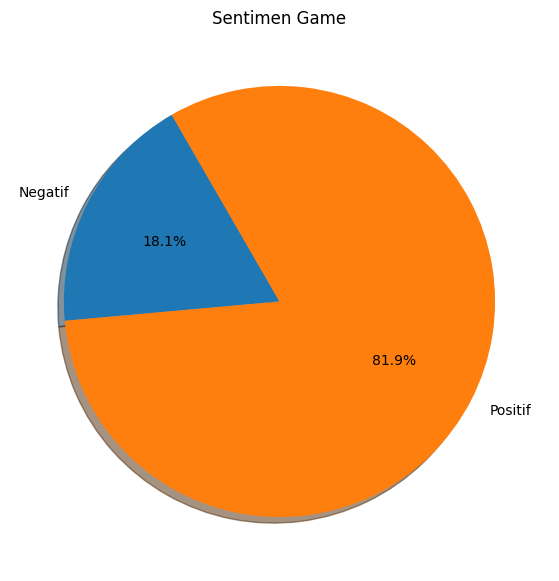

In [5]:
plt.figure(figsize=(15,7))
# sentimen = df.dropna(subset=['sentiments']).sort_values(by=['sentiments'])['sentiments'].unique()
total = df.groupby(['sentiments'])['score'].count()
plt.pie(total, labels=(["Negatif", "Positif"]), autopct='%.1f%%', startangle = 120, shadow = True)
plt.title('Sentimen Game')
plt.show()


#### Visualisasi Pie terhadapat Rating

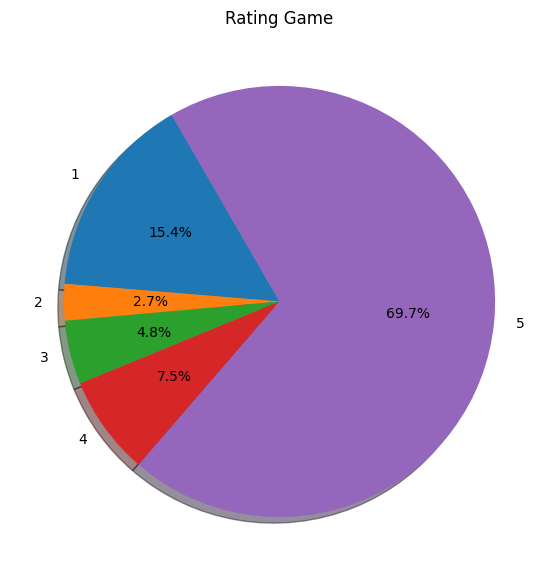

In [6]:
plt.figure(figsize=(15,7))
rating = df.dropna(subset=['score']).sort_values(by=['score'])['score'].unique()
total = df.groupby(['score'])['reviewId'].count()
plt.pie(total, labels=rating, autopct='%.1f%%', startangle = 120, shadow = True)
plt.title('Rating Game')
plt.show()


#### Visualisasi bar terhadapat Rating dan jumlah penggunaan game

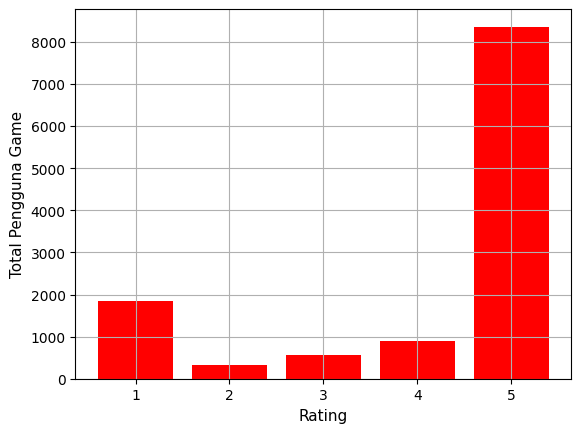

In [7]:
score= df.dropna(subset=['score']).sort_values(by=['score'])['score'].unique()
total = df.groupby(['score'])['reviewId'].count()
plt.bar(score, total, color='red')
# plt.title('')
plt.xlabel('Rating', fontsize=11)
plt.ylabel('Total Pengguna Game', fontsize=11)
plt.grid()
plt.show()

### 4. Data Modeling

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token="<OOV>")

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df['content'], df['sentiments'], test_size=0.4)


In [10]:
import numpy as np
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
for row in x_train:
    training_sentences.append(str(row))
for row in y_train:
    training_labels.append(row)
for row in x_test:
    testing_sentences.append(str(row))
for row in y_test:
    testing_labels.append(row)


In [11]:
vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [12]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

word_index 


{'<OOV>': 1,
 'game': 2,
 'bagus': 3,
 'nya': 4,
 'di': 5,
 'saya': 6,
 'ini': 7,
 'dan': 8,
 'yang': 9,
 'bisa': 10,
 'tapi': 11,
 'sangat': 12,
 'untuk': 13,
 'banget': 14,
 'main': 15,
 'yg': 16,
 'seru': 17,
 'hp': 18,
 'tolong': 19,
 'aku': 20,
 'tidak': 21,
 'ada': 22,
 'keren': 23,
 'genshin': 24,
 'lagi': 25,
 'the': 26,
 'gamenya': 27,
 'gak': 28,
 'buat': 29,
 'update': 30,
 'dari': 31,
 'grafik': 32,
 'banyak': 33,
 'download': 34,
 'juga': 35,
 'aja': 36,
 'udah': 37,
 'ga': 38,
 'good': 39,
 'kasih': 40,
 'i': 41,
 'suka': 42,
 'ya': 43,
 'jadi': 44,
 'bintang': 45,
 'gw': 46,
 'mantap': 47,
 'karakter': 48,
 'gacha': 49,
 'sih': 50,
 'lah': 51,
 'mau': 52,
 '5': 53,
 'lebih': 54,
 'impact': 55,
 'sama': 56,
 '1': 57,
 'sudah': 58,
 'itu': 59,
 'karena': 60,
 'lama': 61,
 'dengan': 62,
 'kalo': 63,
 'padahal': 64,
 'story': 65,
 'cuma': 66,
 'masih': 67,
 'data': 68,
 'nice': 69,
 'baru': 70,
 'sekali': 71,
 'ke': 72,
 '3': 73,
 'gk': 74,
 'hoyoverse': 75,
 'and': 76,
 'te

In [13]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,       input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           640000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 640,109
Trainable params: 640,109
Non-trainable params: 0
_________________________________________________________________


In [17]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)
testing_labels_final

array([1, 1, 0, ..., 0, 1, 0])

In [18]:
num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
225/225 [==============================] - 3s 10ms/step - loss: 0.5199 - accuracy: 0.8164 - val_loss: 0.4569 - val_accuracy: 0.8231
Epoch 2/20
225/225 [==============================] - 2s 9ms/step - loss: 0.4651 - accuracy: 0.8164 - val_loss: 0.4531 - val_accuracy: 0.8231
Epoch 3/20
225/225 [==============================] - 2s 9ms/step - loss: 0.4598 - accuracy: 0.8164 - val_loss: 0.4506 - val_accuracy: 0.8231
Epoch 4/20
225/225 [==============================] - 2s 9ms/step - loss: 0.4533 - accuracy: 0.8163 - val_loss: 0.4426 - val_accuracy: 0.8229
Epoch 5/20
225/225 [==============================] - 2s 9ms/step - loss: 0.4419 - accuracy: 0.8183 - val_loss: 0.4319 - val_accuracy: 0.8248
Epoch 6/20
225/225 [==============================] - 2s 10ms/step - loss: 0.4225 - accuracy: 0.8225 - val_loss: 0.4144 - val_accuracy: 0.8260
Epoch 7/20
225/225 [==============================] - 2s 9ms/step - loss: 0.3947 - accuracy: 0.8294 - val_loss: 0.3948 - val_accuracy: 0.8290
Epoc

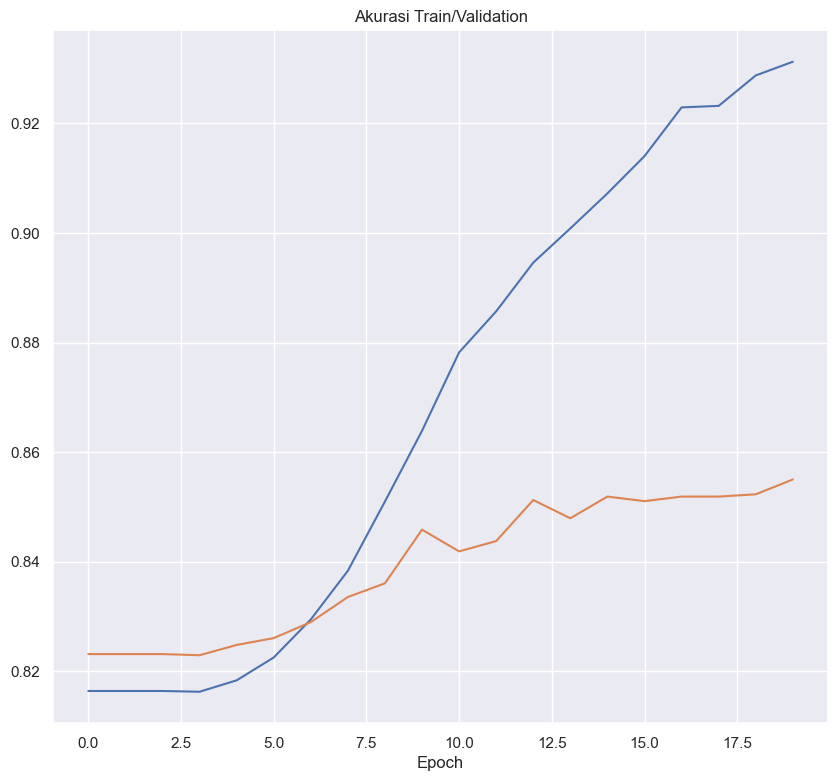

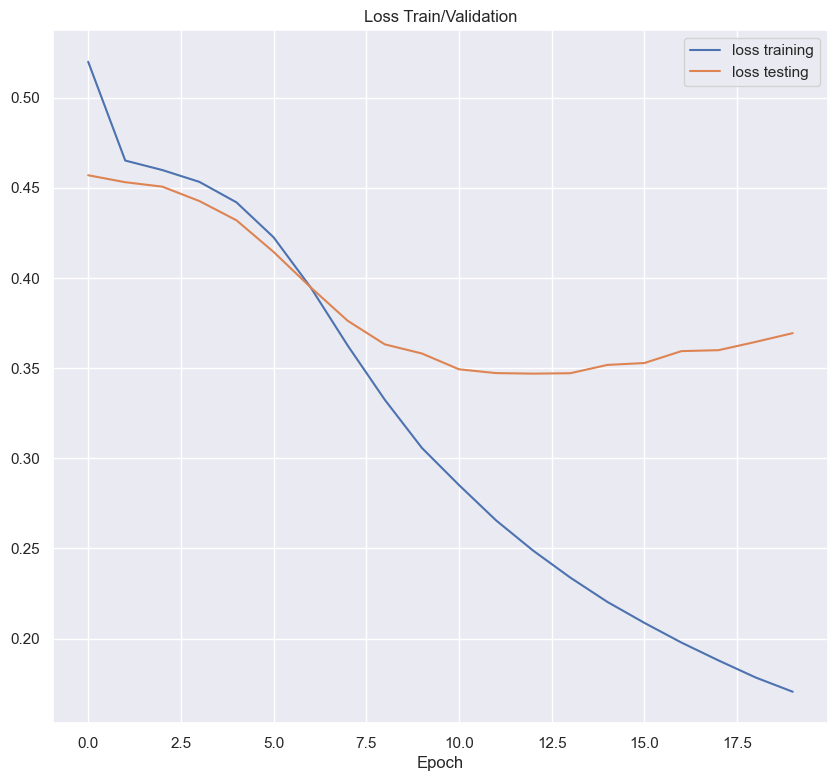

In [86]:
#import library untuk visualisasi yaitu seaborn dan matplotlib
import matplotlib.pyplot as plt

#deklarasi variabel yang menyimpan nilai training dan testing
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#proses visualisasi
plt.figure(figsize=(10,9))

plt.plot(epochs,acc,label='Akurasi Training')
plt.plot(epochs,val_acc,label='Akurasi testing')
plt.xlabel("Epoch")
plt.title("Akurasi Train/Validation")
plt.show()

plt.figure(figsize=(10,9))
sn.lineplot(loss,label='loss training')
sn.lineplot(val_loss,label='loss testing')
plt.xlabel("Epoch")
plt.title("Loss Train/Validation")
plt.show()

In [ ]:
#membuat variabel predict_sentences yang menyimpan kalimat yang nantinya akan di konfersi ke angka 
predict_sentences = tokenizer.texts_to_sequences([
"Gamesnya babi",
"Semakin mantep Update Sumeru. Semua dari update ini saya Suka Semua dari segi Design Charnya, Viewnya, Dan juga Story nya Epic PARAAHHH",
"jelek banget",
"bagus"])
predict_padded = pad_sequences(predict_sentences, maxlen=max_length)

model.predict(predict_padded)